In [34]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import matplotlib.cm as cm
import datetime 
import time
from scipy.fft import fft, ifft, fftshift
from scipy.fftpack import fftfreq

temp = np.zeros((8,64,128))
Q1   = np.zeros((8,64,128))
#for i,lev in enumerate([100]):
for i,lev in enumerate([100, 200, 250, 500,700,850,925,1000]):
    # Open the NetCDF file
    nc_file        = Dataset("t"+str(lev)+'_clim.nc', mode="r")
    temp[i,:,:]    = nc_file.variables["t"][:].mean(axis=0)
    nc_file        = Dataset("Q1"+str(lev)+'_clim.nc', mode="r")
    Q1[i,:,:]      = nc_file.variables["q1"][:].mean(axis=0)
    nc_file.close()
# # Print file metadata
# print(nc_file)

# # Get variable names
# print(nc_file.variables.keys())

# # Access a specific variable
# temp = nc_file.variables["temperature"][:]  # Change "temperature" to a variable in your file
# print(temp)

# # Close file
# nc_file.close()


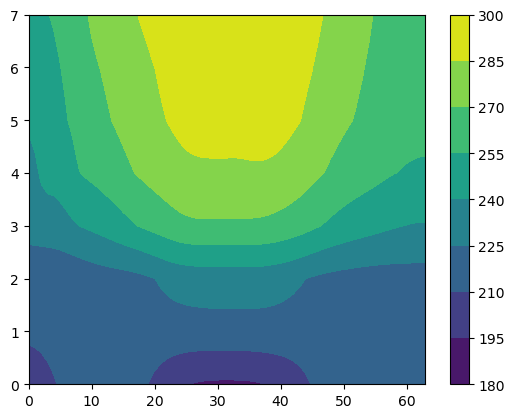

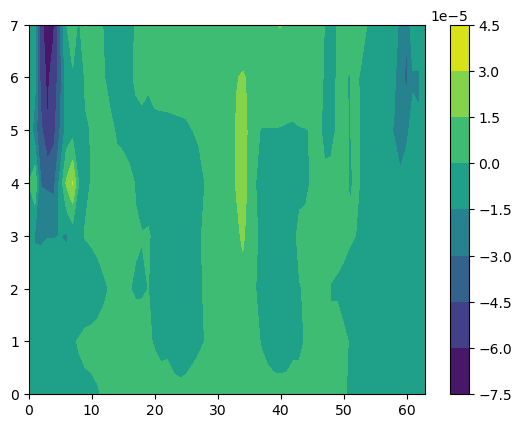

In [35]:
plt.figure()
cs = plt.contourf(temp[:,:,:].mean(axis=(2)))
plt.colorbar(cs)

plt.figure()
cs = plt.contourf(Q1[:,:,:].mean(axis=(2)))
plt.colorbar(cs)

## Load Dycore file for interpolating the ERA5 data into dycore grid 


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import matplotlib.cm as cm
import datetime 
import time
from Load_File import Load_File

def load_file(PR, start_day, end_day, path, load_variable='none'): 
    #count = 0
    for i, day in enumerate(range(start_day, end_day, 25)):
        file_path = path + 'RH80_PR'+str(PR)+'_'+str(end_day)+'day_startfrom_'+str(day)+'day_final.dat'
        # show what variables are available 
        if day == start_day:
            with h5py.File(file_path, "r") as file:
                print(file.keys())
    
        if load_variable == 'none':
            return
        else:
            f       = Load_File(load_variable)
            var_tmp = np.array(f.load_data(file_path))
            #print(var_tmp.shape)
            if day == start_day:
                var = var_tmp
            else:
                var = np.concatenate((var,var_tmp))
                return var
            
    # Print variable names and values
    for var_name, var_value in locals().items():
        print(f"{var_name} = {var_value}")
    
# Example usage
path             = '/home/kaichiht/Colab/2025_research/Dycore_obs_Climatology/IdealizeSpetral.jl/exp/HSt42/HSt42_0/'
#function example: grid_t_p_xyzt = load_file(PR, start_day, end_day, path, variable='grid_t_p_xyzt')
#grid_t_p_xyzt    = load_file(0, 0, 50, path, 'grid_t_p_xyzt')
grid_p_full_xyzt = load_file(0, 0, 50, path, 'grid_p_full_xyzt')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/kaichiht/Colab/2025_research/Dycore_obs_Climatology/IdealizeSpetral.jl/exp/HSt42/HSt42_0/RH80_PR0_50day_startfrom_0day_final.dat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

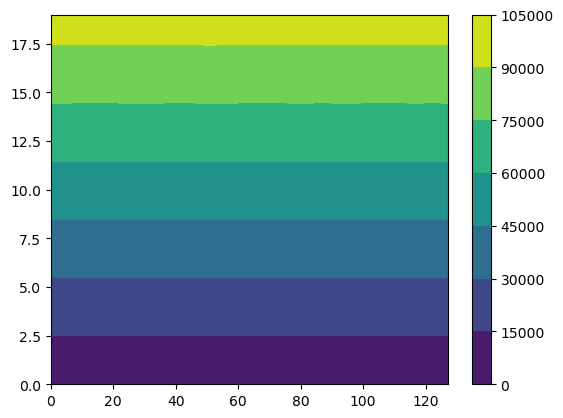

In [7]:
plt.figure()
cs = plt.contourf(grid_p_full_xyzt[:,:,:,:].mean(axis=(0,2)))
plt.colorbar(cs)

In [28]:
Dycore_p = grid_p_full_xyzt[:,:,:,:].mean(axis=(0,2,3))/np.max(grid_p_full_xyzt[:,:,:,:].mean(axis=(0,2,3)))
ERA5_p   = np.array([0.100, 0.200, 0.250, 0.500,0.700,0.850,0.925,1.000])

from scipy.interpolate import interp1d
import numpy as np

temp_Dycore = np.zeros((20,64,128))
Q1_Dycore   = np.zeros((20,64,128))
# Create an interpolation function with extrapolation
for i in range(64):
    for j in range(128):
        f                  = interp1d(ERA5_p, temp[:,i,j], kind="linear", fill_value="extrapolate")
        temp_Dycore[:,i,j] = f(Dycore_p)
        f                  = interp1d(ERA5_p, Q1[:,i,j], kind="linear", fill_value="extrapolate")
        Q1_Dycore[:,i,j]   = f(Dycore_p)


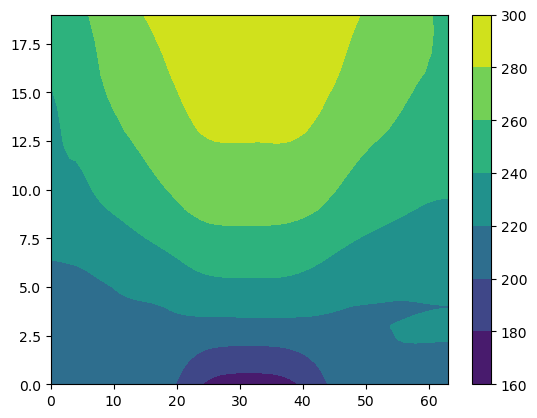

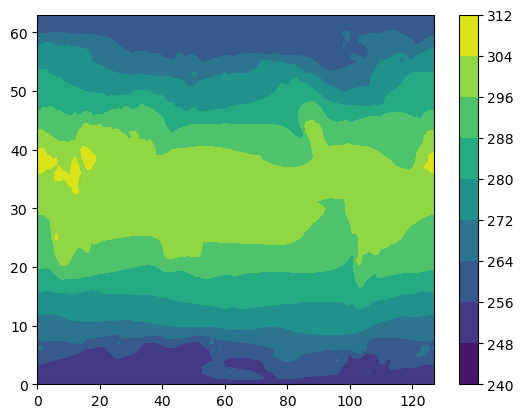

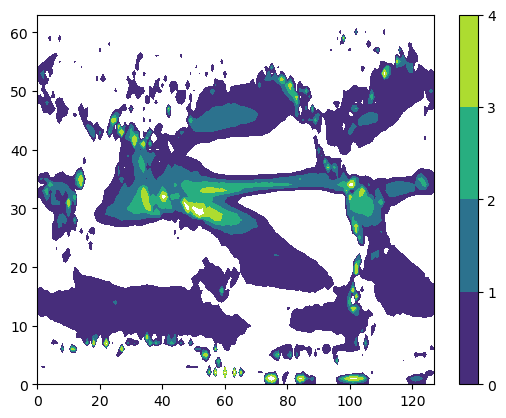

In [31]:
plt.figure()
cs = plt.contourf(temp_Dycore[:,:,:].mean(axis=(2)))
plt.colorbar(cs)
plt.figure()
cs = plt.contourf(temp_Dycore[19,:,:])
plt.colorbar(cs)

plt.figure()
cs = plt.contourf(Q1_Dycore[10,:,:]*86400,levels = np.arange(0,5,1))
plt.colorbar(cs)


In [33]:
import h5py
import numpy as np

## Write Regrid File into and HDF5 file 
file_path = '/home/kaichiht/Colab/2025_research/Dycore_obs_Climatology/IdealizeSpetral.jl/exp/HSt42/obs_theta/'
file_name = 'grid_t_obs.dat'


# Create a new HDF5 file
with h5py.File(file_path+file_name, "w") as hdf:
    # Define data for variable T
    T = np.random.rand(10, 10)  # Example: 10x10 array with random values

    # Create a dataset in the HDF5 file
    hdf.create_dataset("T", data=temp_Dycore)

    # Optionally, add attributes (metadata)
    hdf["T"].attrs["units"] = "Kelvin"
    hdf["T"].attrs["description"] = "Temperature data"

## Write Regrid File into and HDF5 file 
file_path = '/home/kaichiht/Colab/2025_research/Dycore_obs_Climatology/IdealizeSpetral.jl/exp/HSt42/obs_theta/'
file_name = 'grid_Q1.dat'


# Create a new HDF5 file
with h5py.File(file_path+file_name, "w") as hdf:
    # Define data for variable T
    T = np.random.rand(10, 10)  # Example: 10x10 array with random values

    # Create a dataset in the HDF5 file
    hdf.create_dataset("Q1", data=Q1_Dycore)

    # Optionally, add attributes (metadata)
    hdf["Q1"].attrs["units"] = "Kelvin/s"
    hdf["Q1"].attrs["description"] = "Heating data"
    